# ANPR Plate Detection Engine: Step-by-Step Notebook

This notebook demonstrates the main steps for license plate detection based on [ANPR Series Part 2: Advanced Plate Detection Engine](https://henok.cloud/articles/anpr-part-2-plate-detection/).

**Outline:**
1. Import Required Libraries
2. Load and Preprocess the Input Image (using Part 1 pipeline)
3. Detect Contours
4. Geometric Filtering and Aspect Ratio Validation
5. Edge Density and Texture Analysis
6. Visualize Detected Plate Candidates
7. (Optional) Benchmarking and Performance Analysis

---

## 1. Import Required Libraries
We will use OpenCV, NumPy, and Matplotlib, and define helper classes for plate detection.

In [57]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import logging
from typing import List, Tuple, Dict
from dataclasses import dataclass
from enum import Enum

# For notebook display
%matplotlib inline

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

## 2. Load and Preprocess the Input Image

We will load an image and preprocess it using the pipeline from Part 1. Make sure the preprocessing notebook or function is available in your environment.

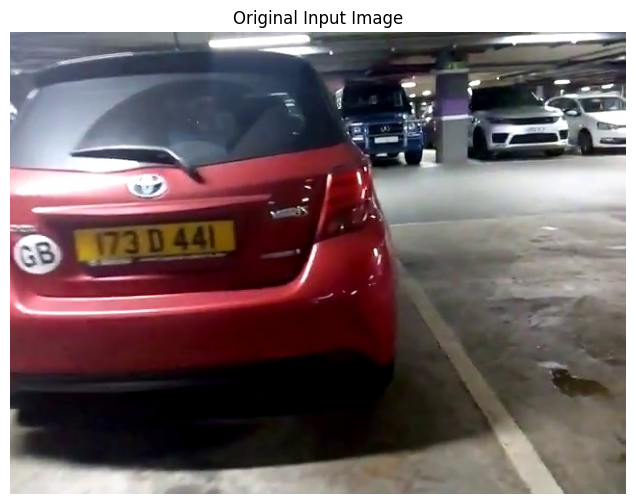

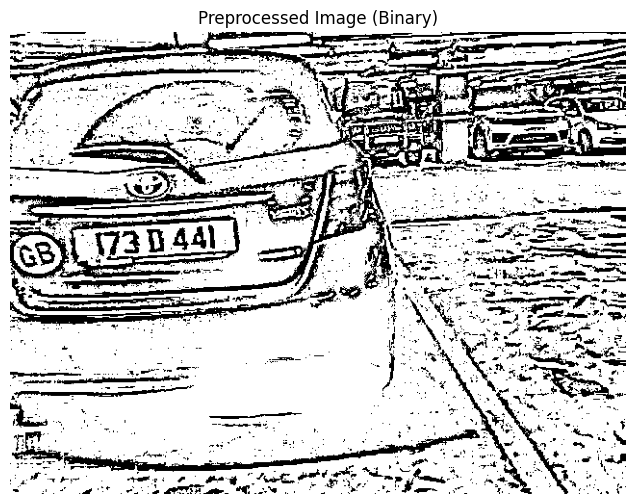

In [58]:
# Load the image (replace with your image path)
image_path = './sample_images/sample_image27.jpg'  # Update this path as needed
image = cv2.imread(image_path)

if image is None:
    raise FileNotFoundError(f"Image not found at {image_path}. Please check the path.")

# Display the original image
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 6))
plt.imshow(image_rgb)
plt.title('Original Input Image')
plt.axis('off')
plt.show()

# Import the preprocessing function from Part 1 (ensure it's available)
# from anpr_image_preprocessing import preprocess_for_anpr
# For demonstration, we'll use a simple threshold as a placeholder:
preprocessed = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
preprocessed = cv2.adaptiveThreshold(preprocessed, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

plt.figure(figsize=(8, 6))
plt.imshow(preprocessed, cmap='gray')
plt.title('Preprocessed Image (Binary)')
plt.axis('off')
plt.show()

## 3. Detect Contours

Find contours in the preprocessed (binary) image. These contours are potential candidates for license plates.

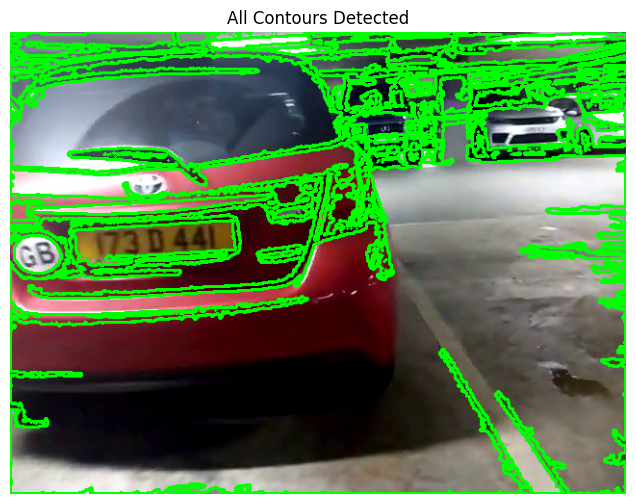

Number of contours found: 288


In [59]:
# Find contours in the preprocessed image
contours, _ = cv2.findContours(preprocessed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw all contours on the image for visualization
contour_img = image_rgb.copy()
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)

plt.figure(figsize=(8, 6))
plt.imshow(contour_img)
plt.title('All Contours Detected')
plt.axis('off')
plt.show()

print(f"Number of contours found: {len(contours)}")

## 4. Geometric Filtering and Aspect Ratio Validation

Filter contours based on geometric properties (area, aspect ratio, size) to find likely plate candidates.

Contour debug info (x, y, w, h, area, aspect_ratio):
  (211, 479, 1, 1, 0.0, 1.00)
  (166, 477, 4, 3, 3.0, 1.33)
  (524, 459, 2, 2, 0.5, 1.00)
  (538, 417, 1, 1, 0.0, 1.00)
  (535, 415, 3, 2, 0.0, 1.50)
  (535, 413, 1, 1, 0.0, 1.00)
  (491, 401, 3, 3, 1.0, 1.00)
  (634, 343, 6, 1, 0.0, 6.00)
  (61, 301, 1, 1, 0.0, 1.00)
  (48, 301, 1, 1, 0.0, 1.00)
  (25, 295, 6, 1, 0.0, 6.00)
  (80, 294, 67, 3, 17.0, 22.33)
  (172, 291, 2, 2, 1.0, 1.00)
  (220, 290, 3, 1, 0.0, 3.00)
  (213, 289, 1, 1, 0.0, 1.00)
  (1, 284, 1, 1, 0.0, 1.00)
  (386, 254, 2, 1, 0.0, 2.00)
  (12, 252, 1, 1, 0.0, 1.00)
  (88, 251, 1, 1, 0.0, 1.00)
  (73, 249, 3, 1, 0.0, 3.00)
  (297, 248, 1, 1, 0.0, 1.00)
  (84, 248, 1, 2, 0.0, 0.50)
  (390, 246, 1, 2, 0.0, 0.50)
  (387, 245, 1, 1, 0.0, 1.00)
  (3, 242, 1, 1, 0.0, 1.00)
  (388, 238, 2, 1, 0.0, 2.00)
  (0, 238, 1, 1, 0.0, 1.00)
  (390, 236, 2, 1, 0.0, 2.00)
  (387, 232, 1, 1, 0.0, 1.00)
  (54, 231, 1, 1, 0.0, 1.00)
  (130, 230, 96, 9, 214.5, 10.67)
  (386, 226, 2, 2, 0.5, 1

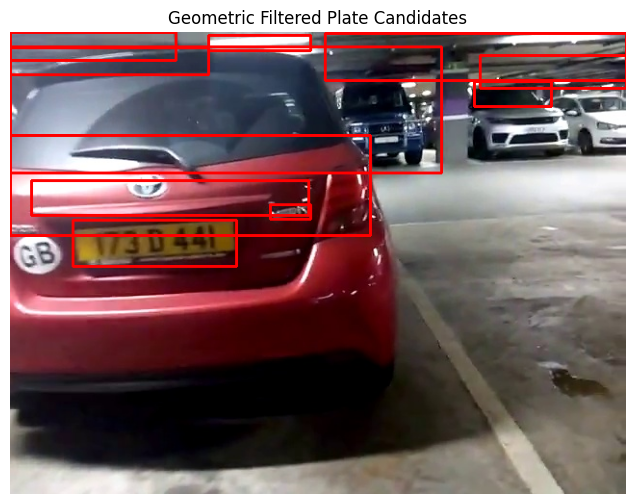

Number of geometric candidates: 11


In [60]:
# Loosened geometric constraints for debugging
min_area = 200  # was 800
max_area = 60000  # was 45000
min_width = 40   # was 120
max_width = 1000 # was 600
min_height = 10  # was 25
max_height = 300 # was 150
aspect_ratio_range = (2.0, 8.0)  # was (3.0, 6.5)

candidates = []
print("Contour debug info (x, y, w, h, area, aspect_ratio):")
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    area = cv2.contourArea(contour)
    aspect_ratio = w / h if h > 0 else 0
    print(f"  ({x}, {y}, {w}, {h}, {area:.1f}, {aspect_ratio:.2f})")
    if (min_area <= area <= max_area and
        min_width <= w <= max_width and
        min_height <= h <= max_height and
        aspect_ratio_range[0] <= aspect_ratio <= aspect_ratio_range[1]):
        candidates.append((x, y, w, h, aspect_ratio, area, contour))

# Draw candidate bounding boxes
candidate_img = image_rgb.copy()
for (x, y, w, h, aspect_ratio, area, contour) in candidates:
    cv2.rectangle(candidate_img, (x, y), (x + w, y + h), (255, 0, 0), 2)

plt.figure(figsize=(8, 6))
plt.imshow(candidate_img)
plt.title('Geometric Filtered Plate Candidates')
plt.axis('off')
plt.show()

print(f"Number of geometric candidates: {len(candidates)}")

## 5. Edge Density and Texture Analysis

Analyze edge density and texture in candidate regions to further validate likely license plates.

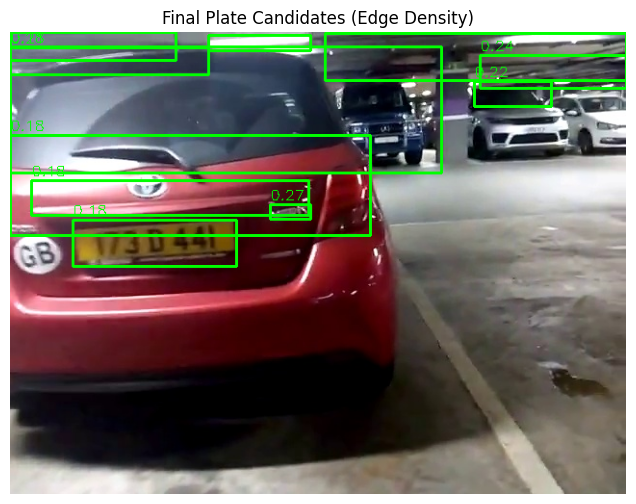

Number of final candidates after edge density: 11


In [61]:
# Analyze edge density for each candidate
edge_density_threshold = (0.1, 0.8)  # Acceptable range for plates
final_candidates = []

for (x, y, w, h, aspect_ratio, area, contour) in candidates:
    roi = preprocessed[y:y+h, x:x+w]
    edges = cv2.Canny(roi, 50, 150)
    edge_pixels = np.sum(edges > 0)
    total_pixels = roi.shape[0] * roi.shape[1]
    density = edge_pixels / total_pixels if total_pixels > 0 else 0
    if edge_density_threshold[0] < density < edge_density_threshold[1]:
        final_candidates.append((x, y, w, h, density))

# Draw final candidates
final_img = image_rgb.copy()
for (x, y, w, h, density) in final_candidates:
    cv2.rectangle(final_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(final_img, f"{density:.2f}", (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

plt.figure(figsize=(8, 6))
plt.imshow(final_img)
plt.title('Final Plate Candidates (Edge Density)')
plt.axis('off')
plt.show()

print(f"Number of final candidates after edge density: {len(final_candidates)}")

## 6. Visualize Detected Plate Candidates

Display the final detected plate candidates on the original image for review.

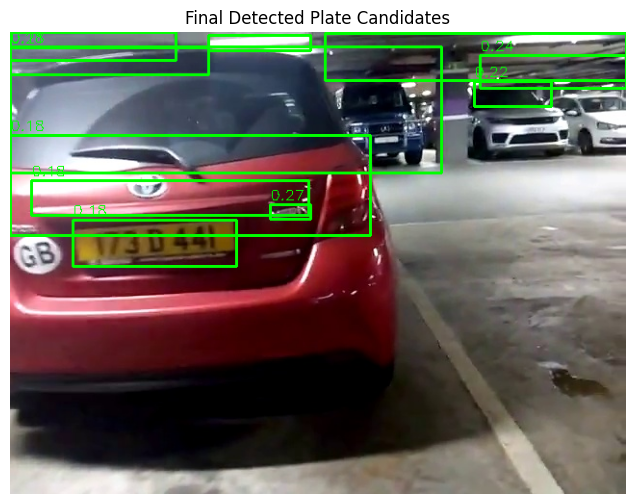

In [62]:
# The final_img with green boxes already shows the detected candidates.
# Optionally, display again for clarity.
plt.figure(figsize=(8, 6))
plt.imshow(final_img)
plt.title('Final Detected Plate Candidates')
plt.axis('off')
plt.show()

## 7. (Optional) Benchmarking and Performance Analysis

You can extend this notebook with benchmarking code to evaluate detection accuracy and speed, as described in the article.